In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from itertools import cycle

import warnings
warnings.filterwarnings('ignore')


pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [3]:
 # 読み込むデータが格納されたディレクトリのパス，必要に応じて変更の必要あり
path = "../data/"

#カレンダー：曜日、イベント、etc
df_calender = pd.read_csv(path + 'calendar.csv')
#売上
df_sales_train_evaluation = pd.read_csv(path + 'sales_train_evaluation.csv')
#販売台数
df_sales_train_validation = pd.read_csv(path + 'sales_train_validation.csv')
#店舗ごとの日別の商品の値段
df_sell_prices = pd.read_csv(path + 'sell_prices.csv')

## データ　df_calender

訓練データセットに含まれるカラムを以下に示します。(テストデータセットにはwinPlacePercカラムは含まれません。)

| カラム名 | 説明 |
| - | - |
| date | 日付 |
| wm_yr_wk | 週のID（同じ週に同じIDを振る |
| weekday | 曜日 |
| wday | 曜日を数字にしているもの |
| month | 月 |
| year | 年 |
| d | 日付ID |
| event_name_1 | イベント名1 |
| event_type_1 | イベントカテゴリ1 |
| event_name_2 | イベント名2 |
| event_type_2 | イベントカテゴリ2 |
| snap_CA | CAの低所得者に対する現金給付制度の有無 |
| snap_TX | CAの低所得者に対する現金給付制度の有無 |
| snap_WI | CAの低所得者に対する現金給付制度の有無 |

### Priceデータ
| カラム名 | 説明 |
| - | - |
| store_id | 店のID |
| item_id | 商品のID |
| wm_yr_wk | 週のID(同じ週に同じIDを振る) |
| sell_price | 商品の金額 |

## sales_train_validation
| カラム名 | 説明 |
| - | - |
| id | ite_id + store_id  |
| item_id | 商品のid |
| dept_id | 商品のカテゴリー（詳細） |
| cat_id | 商品のカテゴリーのid |
| store_id | 店のid |
| state_id | 場所のid |
| d_1など | 日付と売り上げと個数 |

次の１か月間の商品ごとの売上と価格を予測する

In [5]:
print('df_calenderのデータ数は{}、変数は{}種類です。'.format(df_calender.shape[0], df_calender.shape[1]))
print('df_sales_train_evaluationのデータ数は{}、変数は{}種類です。'.format(df_sales_train_evaluation.shape[0], df_sales_train_evaluation.shape[1]))
print('df_sales_train_validationのデータ数は{}、変数は{}種類です。'.format(df_sales_train_validation.shape[0], df_sales_train_validation.shape[1]))
print('df_sell_pricesのデータ数は{}、変数は{}種類です。'.format(df_sell_prices.shape[0], df_sell_prices.shape[1]))

df_calenderのデータ数は1969、変数は14種類です。
df_sales_train_evaluationのデータ数は30490、変数は1947種類です。
df_sales_train_validationのデータ数は30490、変数は1919種類です。
df_sell_pricesのデータ数は6841121、変数は4種類です。


In [16]:
d_cols = [c for c in df_sales_train_evaluation.columns if 'd_' in c]

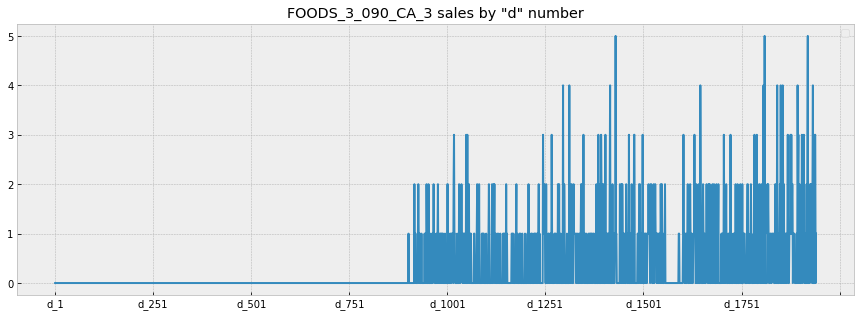

In [17]:
df_sales_train_evaluation.loc[df_sales_train_evaluation['id'] == 'HOBBIES_1_001_CA_1_evaluation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 sales by "d" number')
plt.legend('')
plt.show()

In [18]:
df_sales_train_evaluation_HOBBIES = df_sales_train_evaluation.loc[df_sales_train_evaluation['cat_id'] == 'HOBBIES']

In [19]:
df_sales_train_evaluation_HOBBIES

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28001,HOBBIES_2_145_WI_3_evaluation,HOBBIES_2_145,HOBBIES_2,HOBBIES,WI_3,WI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,...,0,0,0,1,0,0,1,1,0,2,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
28002,HOBBIES_2_146_WI_3_evaluation,HOBBIES_2_146,HOBBIES_2,HOBBIES,WI_3,WI,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28003,HOBBIES_2_147_WI_3_evaluation,HOBBIES_2_147,HOBBIES_2,HOBBIES,WI_3,WI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,2,0,0,0,1,0,0,0,2,0,0,0,0,0,0,2,0,0,0,1,2,0,0,0
28004,HOBBIES_2_148_WI_3_evaluation,HOBBIES_2_148,HOBBIES_2,HOBBIES,WI_3,WI,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,1,0


In [20]:
a = df_sales_train_evaluation_HOBBIES.sum()

In [21]:
hobby = pd.DataFrame(a)

In [22]:
pd.DataFrame(a).index

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938',
       'd_1939', 'd_1940', 'd_1941'],
      dtype='object', length=1947)

In [23]:
hobby = hobby.filter(like='d_', axis=0)

In [25]:
hobby

,0
d_1,3764
d_2,3357
d_3,2682
d_4,2669
d_5,1814
...,...
d_1937,3740
d_1938,3475
d_1939,4143
d_1940,5333


<AxesSubplot:title={'center':'HOBBIES'}>

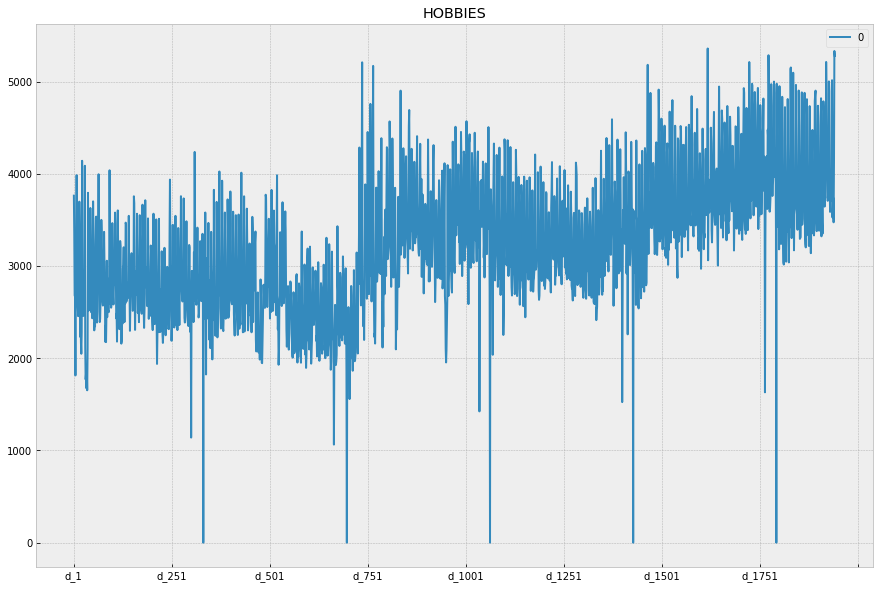

In [24]:
hobby.plot(figsize=(15, 10),
          title='HOBBIES')

<AxesSubplot:title={'center':'HOBBIES'}>

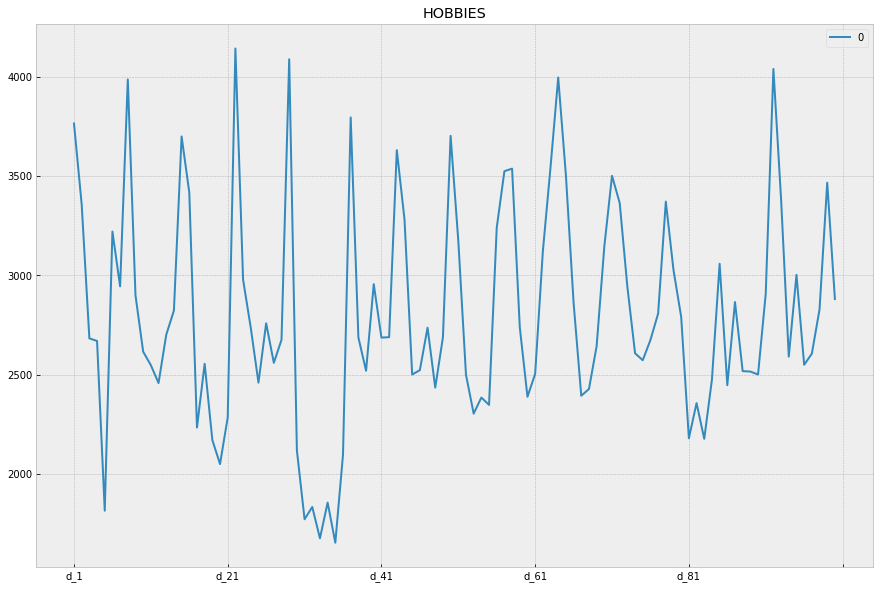

In [15]:
hobby[0:10]
hobby[0:100].plot(figsize=(15, 10),
          title='HOBBIES')

In [104]:
df_calender = pd.read_csv(path + 'calendar.csv')

In [105]:
for i in df_calender['event_name_1'].unique():
    if not pd.isnull(i):
        df_calender[i] = 0

In [106]:
#イベントがある日に対応するカラムを366にする
for index, row in df_calender.iterrows():
    if not pd.isnull(row['event_name_1']):
        df_calender.at[index, row['event_name_1']] = 366

In [107]:
for i in df_calender['event_name_1'].unique():
    if not pd.isnull(i):
        ColumnName = i
        list_day = list()
        for index, row in df_calender.iterrows():
            if row[ColumnName] == 0:
                list_day.append(index)
            else:
                for i in list_day:
                    df_calender.at[i, [ColumnName]] = (366-(len(list_day)-list_day.index(i)))
                list_day = list()
        for i in list_day:
                df_calender.at[i, [ColumnName]] = (366-(366-list_day.index(i)))

<AxesSubplot:title={'center':'HOBBIES'}>

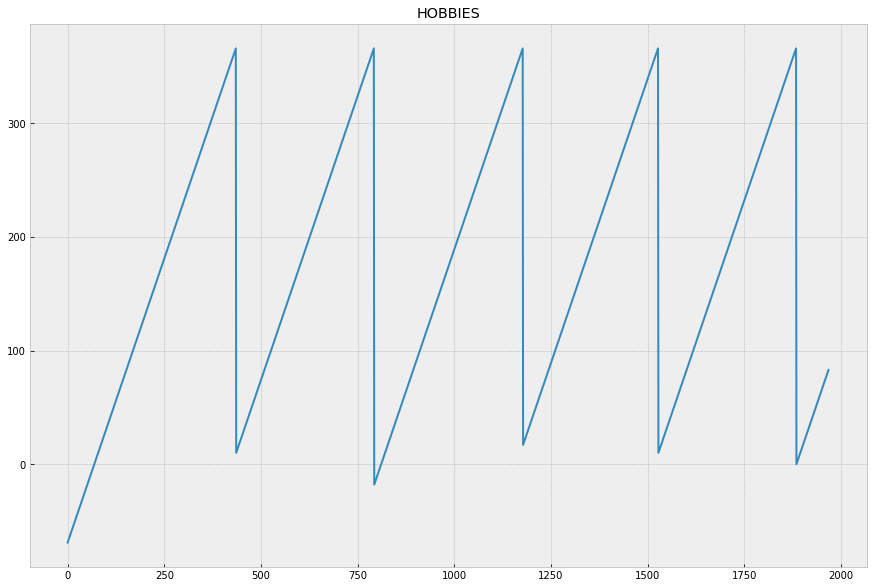

In [108]:
df_calender["Easter"].plot(figsize=(15, 10),
          title='HOBBIES')

In [12]:
df_calender

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,SuperBowl,ValentinesDay,PresidentsDay,LentStart,LentWeek2,StPatricksDay,Purim End,OrthodoxEaster,Pesach End,Cinco De Mayo,Mother's day,MemorialDay,NBAFinalsStart,NBAFinalsEnd,Father's day,IndependenceDay,Ramadan starts,Eid al-Fitr,LaborDay,ColumbusDay,Halloween,EidAlAdha,VeteransDay,Thanksgiving,Christmas,Chanukah End,NewYear,OrthodoxChristmas,MartinLutherKingDay,Easter
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,358,350,343,327,320,319,316,281,279,270,267,245,244,232,225,210,182,152,147,112,91,84,80,67,36,33,29,23,14,-69
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,359,351,344,328,321,320,317,282,280,271,268,246,245,233,226,211,183,153,148,113,92,85,81,68,37,34,30,24,15,-68
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,360,352,345,329,322,321,318,283,281,272,269,247,246,234,227,212,184,154,149,114,93,86,82,69,38,35,31,25,16,-67
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,361,353,346,330,323,322,319,284,282,273,270,248,247,235,228,213,185,155,150,115,94,87,83,70,39,36,32,26,17,-66
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,362,354,347,331,324,323,320,285,283,274,271,249,248,236,229,214,186,156,151,116,95,88,84,71,40,37,33,27,18,-65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1,128,121,120,125,118,89,82,44,45,40,37,15,12,362,359,346,7,332,281,246,227,264,216,201,172,183,165,159,148,79
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0,129,122,121,126,119,90,83,45,46,41,38,16,13,363,360,347,8,333,282,247,228,265,217,202,173,184,166,160,149,80
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0,130,123,122,127,120,91,84,46,47,42,39,17,14,364,361,348,9,334,283,248,229,266,218,203,174,185,167,161,150,81
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0,131,124,123,128,121,92,85,47,48,43,40,18,15,365,362,349,10,335,284,249,230,267,219,204,175,186,168,162,151,82


In [ ]:
df_calender["SuperBowl"]

In [26]:
hobby

,0
d_1,3764
d_2,3357
d_3,2682
d_4,2669
d_5,1814
...,...
d_1937,3740
d_1938,3475
d_1939,4143
d_1940,5333


イベントと売上の相関を見ていく

In [109]:
df_calender_test = df_calender[:1941]

In [110]:
hobby_test = hobby.reset_index(drop=True)

In [111]:
df_calender_test = pd.concat([df_calender_test, hobby_test], axis=1)

In [112]:
df_calender_test = df_calender_test.rename(columns={0: 'AAAAAAAAAAAAAAAAAAAAAAA'})

In [113]:
df_calender_test["AAAAAAAAAAAAAAAAAAAAAAA"].dtype

dtype('O')

In [114]:
df_calender_test['AAAAAAAAAAAAAAAAAAAAAAA'] = df_calender_test['AAAAAAAAAAAAAAAAAAAAAAA'].astype(int)

In [115]:
df_calender_test

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,SuperBowl,ValentinesDay,PresidentsDay,LentStart,LentWeek2,StPatricksDay,Purim End,OrthodoxEaster,Pesach End,Cinco De Mayo,Mother's day,MemorialDay,NBAFinalsStart,NBAFinalsEnd,Father's day,IndependenceDay,Ramadan starts,Eid al-Fitr,LaborDay,ColumbusDay,Halloween,EidAlAdha,VeteransDay,Thanksgiving,Christmas,Chanukah End,NewYear,OrthodoxChristmas,MartinLutherKingDay,Easter,AAAAAAAAAAAAAAAAAAAAAAA
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,358,350,343,327,320,319,316,281,279,270,267,245,244,232,225,210,182,152,147,112,91,84,80,67,36,33,29,23,14,-69,3764
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,359,351,344,328,321,320,317,282,280,271,268,246,245,233,226,211,183,153,148,113,92,85,81,68,37,34,30,24,15,-68,3357
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,360,352,345,329,322,321,318,283,281,272,269,247,246,234,227,212,184,154,149,114,93,86,82,69,38,35,31,25,16,-67,2682
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,361,353,346,330,323,322,319,284,282,273,270,248,247,235,228,213,185,155,150,115,94,87,83,70,39,36,32,26,17,-66,2669
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,362,354,347,331,324,323,320,285,283,274,271,249,248,236,229,214,186,156,151,116,95,88,84,71,40,37,33,27,18,-65,1814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,2016-05-18,11616,Wednesday,5,5,2016,d_1937,NaN,NaN,NaN,NaN,0,0,0,100,93,92,97,90,61,54,16,17,12,9,354,351,334,331,318,346,304,253,218,199,236,188,173,144,155,137,131,120,51,3740
1937,2016-05-19,11616,Thursday,6,5,2016,d_1938,NaN,NaN,NaN,NaN,0,0,0,101,94,93,98,91,62,55,17,18,13,10,355,352,335,332,319,347,305,254,219,200,237,189,174,145,156,138,132,121,52,3475
1938,2016-05-20,11616,Friday,7,5,2016,d_1939,NaN,NaN,NaN,NaN,0,0,0,102,95,94,99,92,63,56,18,19,14,11,356,353,336,333,320,348,306,255,220,201,238,190,175,146,157,139,133,122,53,4143
1939,2016-05-21,11617,Saturday,1,5,2016,d_1940,NaN,NaN,NaN,NaN,0,0,0,103,96,95,100,93,64,57,19,20,15,12,357,354,337,334,321,349,307,256,221,202,239,191,176,147,158,140,134,123,54,5333


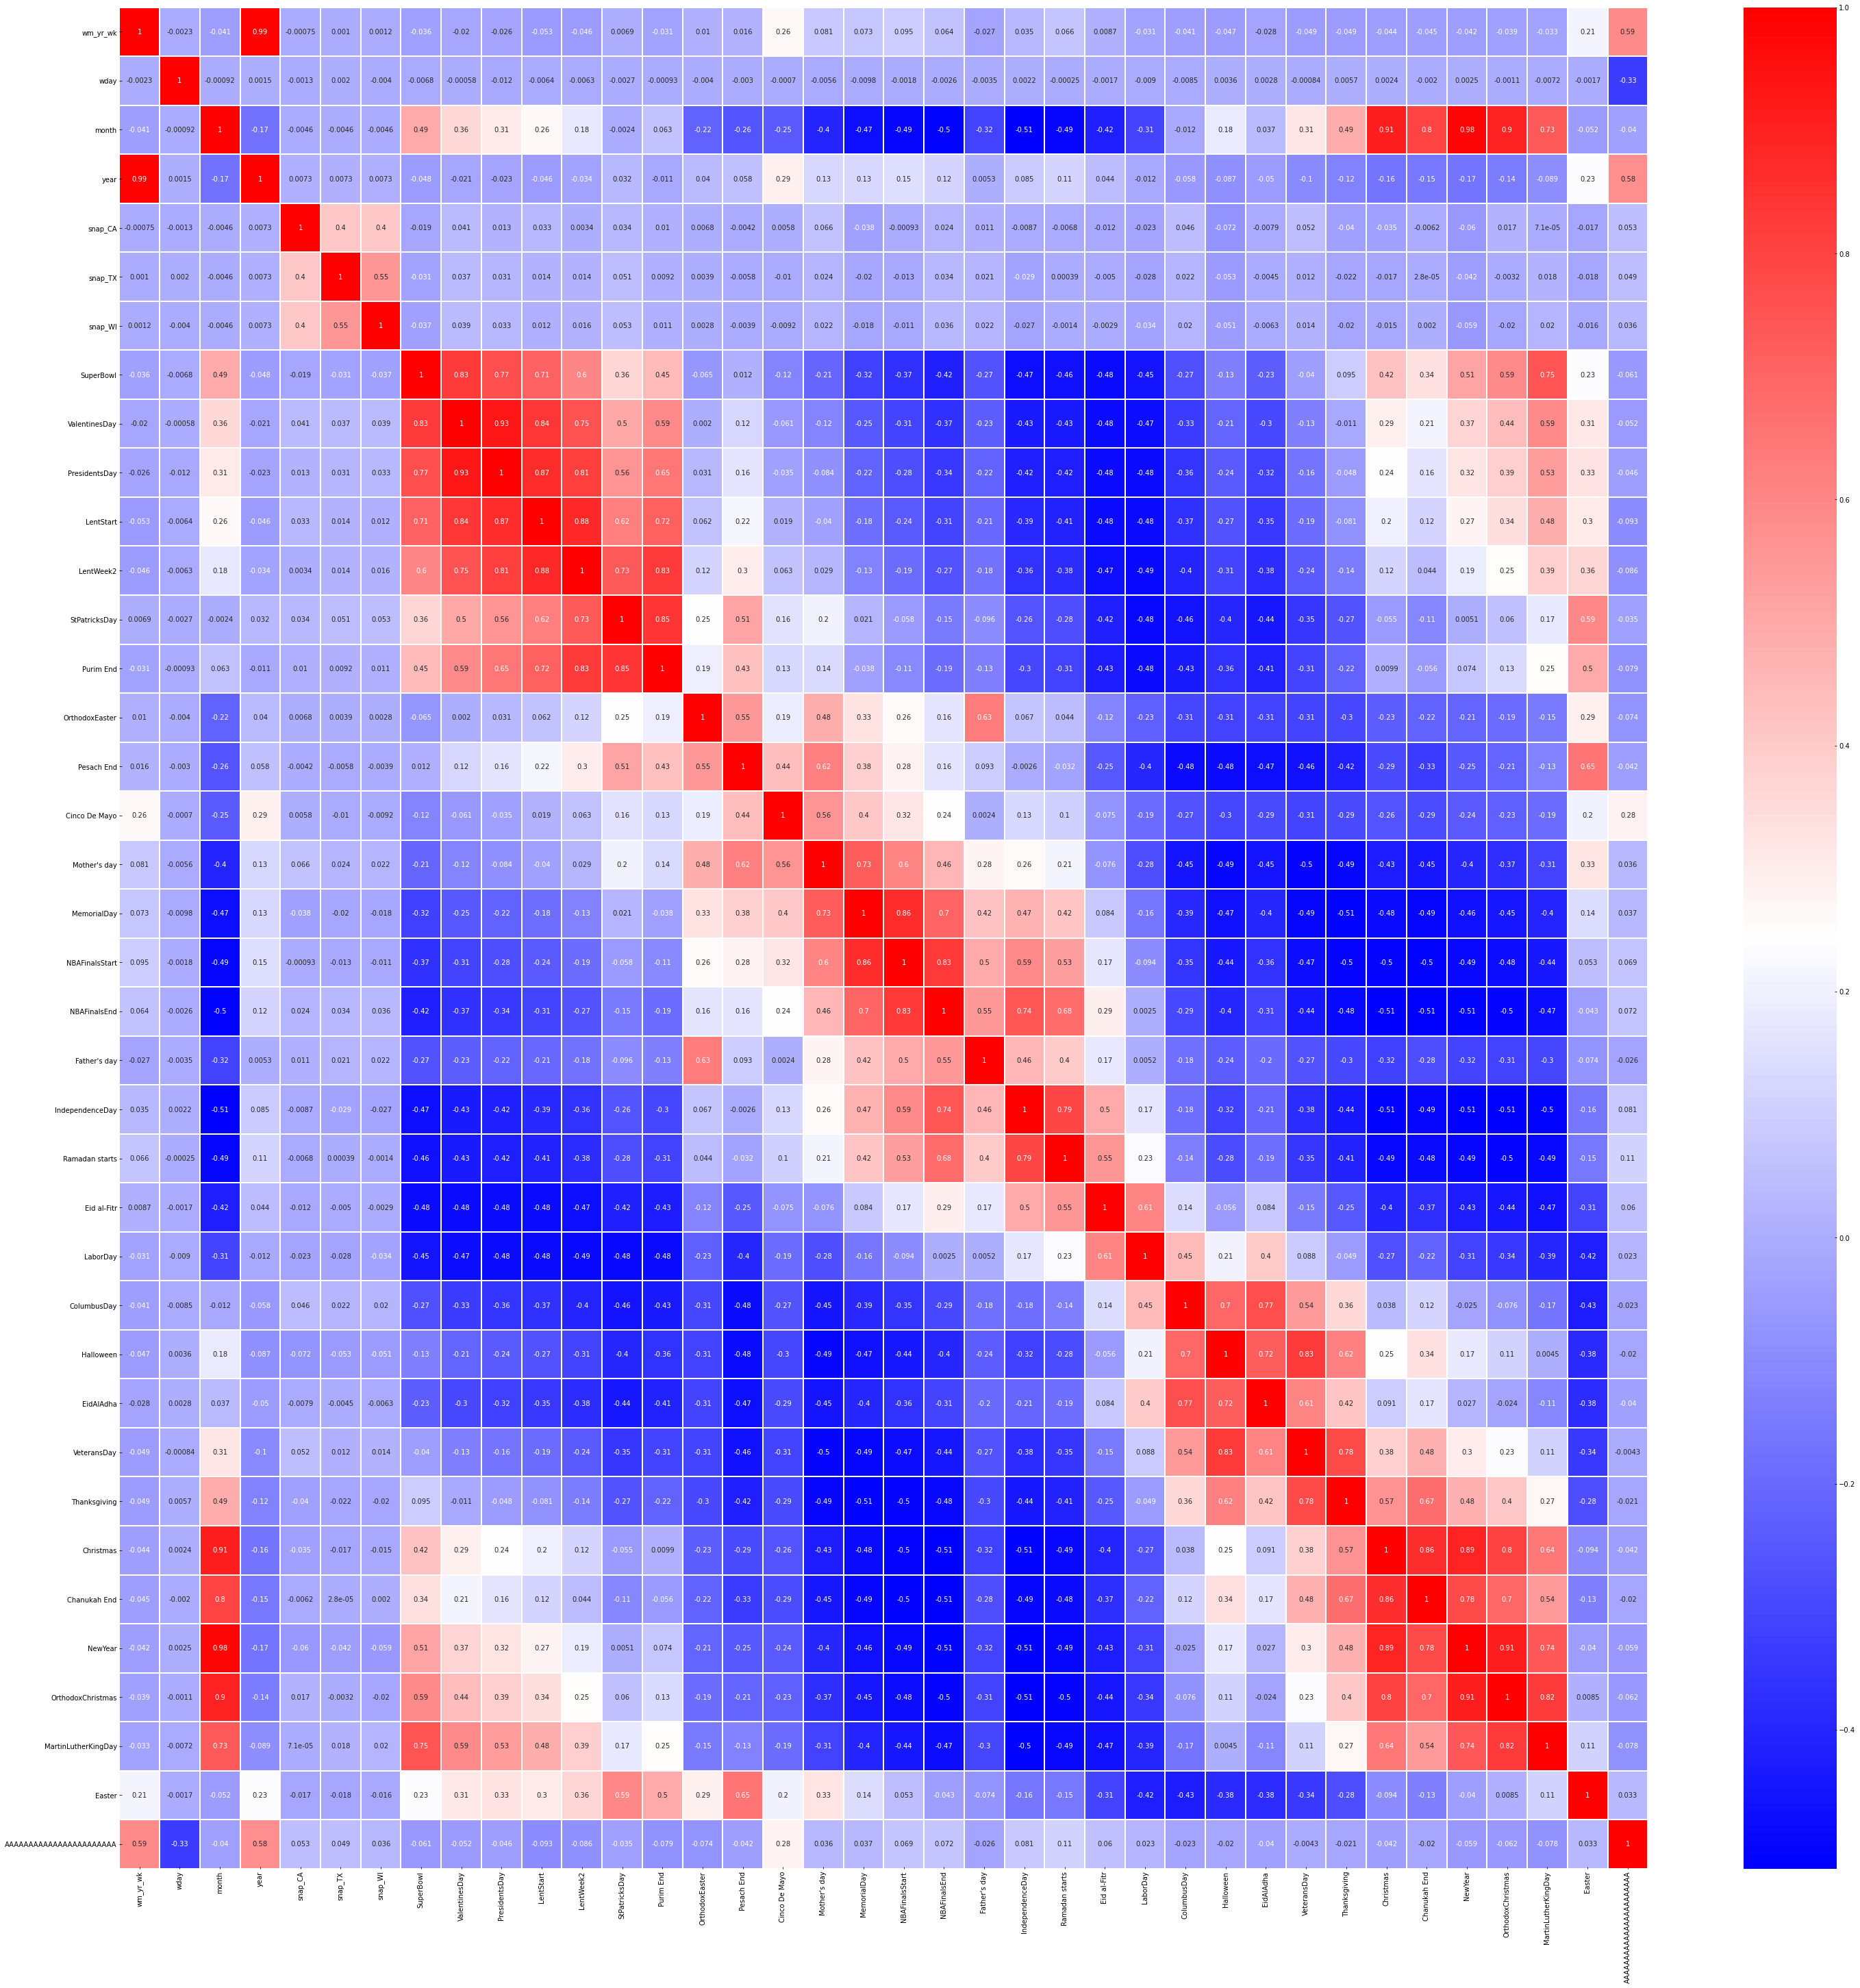

In [116]:
plt.figure(figsize = (50,50))
sns.heatmap(df_calender_test.corr(),annot=True,cmap='bwr',linewidths=0.2) 
fig=plt.gcf()
plt.show()

In [40]:
type(df_calender_test)

pandas.core.frame.DataFrame

In [16]:
df_calender.columns

Index(['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI'],
      dtype='object')

In [18]:
df_calender.isnull().sum()

date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

In [19]:
df_sales_train_evaluation.isnull().sum()

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1937      0
d_1938      0
d_1939      0
d_1940      0
d_1941      0
Length: 1947, dtype: int64

In [20]:
df_sales_train_validation.isnull().sum()

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1909      0
d_1910      0
d_1911      0
d_1912      0
d_1913      0
Length: 1919, dtype: int64

In [21]:
df_sell_prices.isnull().sum()

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64

商品ごと、店舗ごとにソートして、時系列の推移や相関を見る